# Critical Difference diagram

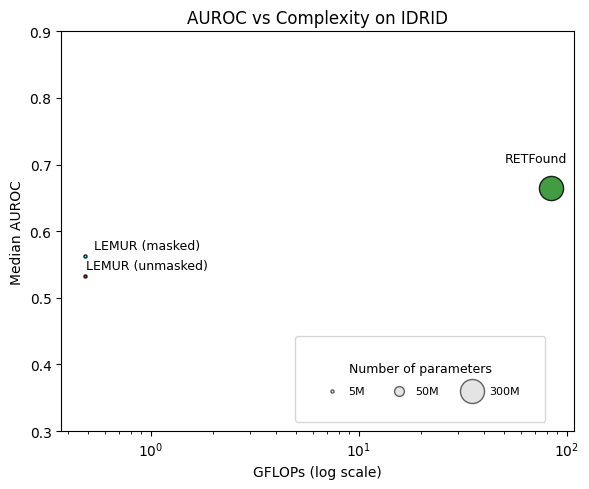

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

SIZE_SCALE = 1e6

# ---------------------------
# 1. Load data
# ---------------------------
df = pd.read_csv("results/eval_results.csv")

# ---------------------------
# 2. Filter IDRID + models
# ---------------------------
df = df[df["dataset"] == "idrid"]
df = df[df["model"].isin(["vmamba_aptos", "retfound_aptos"])]

# ---------------------------
# 3. Median AUROC
# ---------------------------
summary = (
    df.groupby(["model", "mask"])["eval/auroc"]
      .median()
      .reset_index()
)

# ---------------------------
# 4. Map GFLOPs + params
# ---------------------------
gflops_map = {
    "vmamba_aptos": 0.48,
    "retfound_aptos": 83.63
}

params_map = {
    "vmamba_aptos": 4.9e6,
    "retfound_aptos": 303e6
}

summary["gflops"] = summary["model"].map(gflops_map)
summary["params"] = summary["model"].map(params_map)

# ---------------------------
# 5. Labels + colors
# ---------------------------
labels = []
colors = []

for _, row in summary.iterrows():
    if row["model"] == "vmamba_aptos" and row["mask"] == "masked":
        labels.append("LEMUR (masked)")
        colors.append("cyan")
    elif row["model"] == "vmamba_aptos" and row["mask"] == "unmasked":
        labels.append("LEMUR (unmasked)")
        colors.append("red")
    elif row["model"] == "retfound_aptos":
        labels.append("RETFound")
        colors.append("forestgreen")

# ---------------------------
# 6. Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(6,5))

for i, row in summary.iterrows():
    ax.scatter(
        row["gflops"],
        row["eval/auroc"],
        s=row["params"] / SIZE_SCALE,
        c=colors[i],
        edgecolors="black",
        alpha=0.85,
        zorder=3
    )

    offset = 0.02 if "RETFound" in labels[i] else 0.01
    x = row["gflops"]
    y = row["eval/auroc"] + offset

    if "LEMUR" in labels[i]:
        x = x * 2.0
    elif "RETFound" in labels[i]:
        x = x * 0.85 # shift RETFound left
        y = y + 0.02
    ax.text(x, y, labels[i], ha="center", fontsize=9)

# ---------------------------
# 6.5 Center arrow + text (axes coordinates)
# ---------------------------

# ---------------------------
# 7. Bubble-size legend
# ---------------------------
for p in [5e6, 50e6, 300e6]:
    ax.scatter([], [], s=p/SIZE_SCALE, c="lightgray",
               edgecolors="black", alpha=0.6,
               label=f"{int(p/1e6)}M")

legend1 = ax.legend(
    title="Number of parameters",
    loc="lower center",
    bbox_to_anchor=(0.7, 0.01),
    ncol=3,
    fontsize=8,
    title_fontsize=9,
    frameon=True,
    borderpad=2.3,
    labelspacing=1.0,
    handletextpad=0.5,
    columnspacing=2.0
)

# ---------------------------
# 8. Formatting
# ---------------------------
ax.set_xscale("log")
ax.set_xlabel("GFLOPs (log scale)")
ax.set_ylabel("Median AUROC")
ax.set_title("AUROC vs Complexity on IDRID")
ax.grid(False)
ax.set_ylim(0.30, 0.90)

plt.tight_layout()
plt.savefig("images/vmamba_retfound_complexity.pdf", bbox_inches="tight")
plt.show()

In [79]:
import pandas as pd
import numpy as np

df = pd.read_csv("results/eval_results.csv")

metrics = ["eval/acc", "eval/f1", "eval/auroc", "eval/aupr"]

# Mean and std over seeds
summary = (
    df.groupby(["model", "mask", "dataset"])[metrics]
      .agg(["mean", "std"])
      .reset_index()
)

def fmt(m, s):
    return f"{m:.3f} $\\pm$ {s:.3f}"

rows = []
for _, row in summary.iterrows():
    model = row[("model", "")]
    mask = row[("mask", "")]
    dataset = row[("dataset", "")]

    rows.append({
        "BaseModel": model,
        "Model": f"{model} ({mask})",
        "Dataset": str(dataset).upper(),
        "Acc": fmt(row[("eval/acc", "mean")], row[("eval/acc", "std")]),
        "F1": fmt(row[("eval/f1", "mean")], row[("eval/f1", "std")]),
        "AUROC": fmt(row[("eval/auroc", "mean")], row[("eval/auroc", "std")]),
        "AUPR": fmt(row[("eval/aupr", "mean")], row[("eval/aupr", "std")]),
    })

table_df = pd.DataFrame(rows)

# Export one LaTeX table per base model
for base_model in table_df["BaseModel"].unique():
    sub = table_df[table_df["BaseModel"] == base_model]
    sub = sub[["Model", "Dataset", "Acc", "F1", "AUROC", "AUPR"]]

    latex = sub.to_latex(index=False, escape=False)

    print(f"\n\n% ===== Table for {base_model} =====")
    print(latex)



% ===== Table for retfound_aptos =====
\begin{tabular}{llllll}
\toprule
Model & Dataset & Acc & F1 & AUROC & AUPR \\
\midrule
retfound_aptos (unmasked) & IDRID & 0.317 $\pm$ 0.045 & 0.255 $\pm$ 0.038 & 0.664 $\pm$ 0.015 & 0.319 $\pm$ 0.015 \\
retfound_aptos (unmasked) & MBRSET & 0.725 $\pm$ 0.028 & 0.236 $\pm$ 0.025 & 0.626 $\pm$ 0.017 & 0.249 $\pm$ 0.006 \\
\bottomrule
\end{tabular}



% ===== Table for retfound_idrid =====
\begin{tabular}{llllll}
\toprule
Model & Dataset & Acc & F1 & AUROC & AUPR \\
\midrule
retfound_idrid (unmasked) & APTOS & 0.439 $\pm$ 0.095 & 0.268 $\pm$ 0.033 & 0.603 $\pm$ 0.040 & 0.271 $\pm$ 0.026 \\
retfound_idrid (unmasked) & MBRSET & 0.674 $\pm$ 0.096 & 0.216 $\pm$ 0.016 & 0.587 $\pm$ 0.035 & 0.230 $\pm$ 0.013 \\
\bottomrule
\end{tabular}



% ===== Table for vmamba_aptos =====
\begin{tabular}{llllll}
\toprule
Model & Dataset & Acc & F1 & AUROC & AUPR \\
\midrule
vmamba_aptos (masked) & IDRID & 0.213 $\pm$ 0.051 & 0.146 $\pm$ 0.029 & 0.554 $\pm$ 0.021 & 0.

In [80]:
import pandas as pd
import numpy as np

df = pd.read_csv("results/eval_results.csv")

metrics = ["eval/acc", "eval/f1", "eval/auroc", "eval/aupr"]

# Mean and std over seeds
summary = (
    df.groupby(["model", "mask", "dataset"])[metrics]
      .agg(["mean", "std"])
      .reset_index()
)

def fmt(m, s):
    return f"{m:.3f} $\\pm$ {s:.3f}"

rows = []
for _, row in summary.iterrows():
    model = row[("model", "")]
    mask = row[("mask", "")]
    dataset = row[("dataset", "")]

    rows.append({
        "Model": f"{model} ({mask})",
        "Dataset": str(dataset).upper(),
        "Acc": fmt(row[("eval/acc", "mean")], row[("eval/acc", "std")]),
        "F1": fmt(row[("eval/f1", "mean")], row[("eval/f1", "std")]),
        "AUROC": fmt(row[("eval/auroc", "mean")], row[("eval/auroc", "std")]),
        "AUPR": fmt(row[("eval/aupr", "mean")], row[("eval/aupr", "std")]),
    })

table_df = pd.DataFrame(rows)

# Optional: sort nicely
table_df = table_df.sort_values(["Model", "Dataset"])

# Export ONE LaTeX table
latex = table_df.to_latex(index=False, escape=False)

print(latex)

\begin{tabular}{llllll}
\toprule
Model & Dataset & Acc & F1 & AUROC & AUPR \\
\midrule
retfound_aptos (unmasked) & IDRID & 0.317 $\pm$ 0.045 & 0.255 $\pm$ 0.038 & 0.664 $\pm$ 0.015 & 0.319 $\pm$ 0.015 \\
retfound_aptos (unmasked) & MBRSET & 0.725 $\pm$ 0.028 & 0.236 $\pm$ 0.025 & 0.626 $\pm$ 0.017 & 0.249 $\pm$ 0.006 \\
retfound_idrid (unmasked) & APTOS & 0.439 $\pm$ 0.095 & 0.268 $\pm$ 0.033 & 0.603 $\pm$ 0.040 & 0.271 $\pm$ 0.026 \\
retfound_idrid (unmasked) & MBRSET & 0.674 $\pm$ 0.096 & 0.216 $\pm$ 0.016 & 0.587 $\pm$ 0.035 & 0.230 $\pm$ 0.013 \\
vmamba_aptos (masked) & IDRID & 0.213 $\pm$ 0.051 & 0.146 $\pm$ 0.029 & 0.554 $\pm$ 0.021 & 0.240 $\pm$ 0.009 \\
vmamba_aptos (masked) & MBRSET & 0.590 $\pm$ 0.190 & 0.180 $\pm$ 0.009 & 0.498 $\pm$ 0.016 & 0.201 $\pm$ 0.004 \\
vmamba_aptos (unmasked) & IDRID & 0.193 $\pm$ 0.038 & 0.129 $\pm$ 0.016 & 0.530 $\pm$ 0.013 & 0.236 $\pm$ 0.009 \\
vmamba_aptos (unmasked) & MBRSET & 0.755 $\pm$ 0.016 & 0.180 $\pm$ 0.009 & 0.544 $\pm$ 0.020 & 0.210 